In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd

In [3]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("X_train.csv")

In [5]:
answers = pd.read_csv("y_train.csv")

In [6]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [7]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [8]:
window_size = 64
overlap = 32   

In [9]:
def get_spectrogramm(ecg, should_log = False, show = False):
    f,t,x = signal.spectral.spectrogram(
                        ecg, 
                        window=("tukey", 0.25),
                        nperseg=window_size, 
                        noverlap=overlap, 
                        return_onesided=True) 
    
            
    if (should_log):    
        x = np.log(x + 1e-8)
    x = x.astype(np.float32)
    
    if (show):
        plt.pcolormesh(t, f, x)

    return x

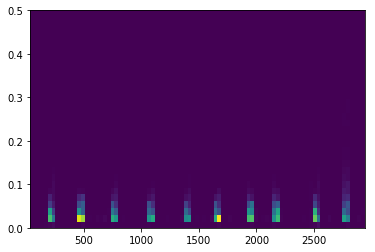

In [10]:
spectro = get_spectrogramm(data.values[0][2:3003], False, True)

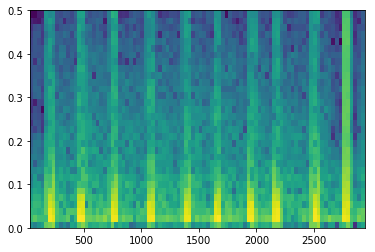

In [11]:
spectro = get_spectrogramm(data.values[0][2:3003], True, True)

In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [14]:
from filters import bandpass_filter

In [15]:
class ECGSpectroDataset(Dataset):
    def __init__(self, data, signal_length):
        super().__init__()
        self.data = data.values
        self._process_dataset()
        self.signal_length = signal_length
        used_data = self.signals
        used_data = [np.array(row) for row in used_data.copy()]
        used_data = np.array(used_data)
        self.mean = used_data.mean()
        self.std = used_data.std()
        self.values = (used_data - used_data.mean())/used_data.std()
     
    def __len__(self):
        return len(self.values)

        
    def _get_row(self, row):
        return [bandpass_filter(row[i : i + 5000], {}) for i in range(2, 55003, 5000)]
        
    def _process_dataset(self):
        self.signals = np.apply_along_axis(lambda x: self._get_row(x), 1, self.data)


    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        cut_point = 0 if self.signal_length >= 5000 else np.random.randint(5001 - self.signal_length)
        signals = self.signals[idx][:, cut_point:cut_point+self.signal_length]
        
        images = np.zeros((12,33,92), dtype=np.float32)
        for i in range(12):
            images[i] = get_spectrogramm(signals[i], should_log=True)
        
        return images, self.data[idx][-1]

In [16]:
class TestECGDataset(Dataset):
    def __init__(self, data, signal_length, train_mean, train_std):
        super().__init__()
        self.data = data.values
        self._process_dataset()
        self.signal_length = signal_length
        used_data = self.signals
        used_data = [np.array(row) for row in used_data.copy()]
        used_data = np.array(used_data)
        self.values = (used_data - train_mean)/train_std


    def __len__(self):
        return len(self.values)

        
    def _get_row(self, row):
        return [bandpass_filter(row[i : i + 5000], {}) for i in range(2, 55003, 5000)]
        
    def _process_dataset(self):
        self.signals = np.apply_along_axis(lambda x: self._get_row(x), 1, self.data)

        
    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        cut_point = 0 if self.signal_length >= 5000 else np.random.randint(5001 - self.signal_length)
        signals = self.signals[idx][:, cut_point:cut_point+self.signal_length]
        
        images = np.zeros((12,33,92), dtype=np.float32)
        for i in range(12):
            images[i] = get_spectrogramm(signals[i], should_log=True)
        return images, self.data[idx][-1]

In [17]:
dataset = ECGSpectroDataset(data, 3000)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [18]:
ecg_loader = DataLoader(dataset, batch_size= 2)

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler

In [20]:
valid_size = 0.1
random_seed = 7

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))


np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_dataset = ECGSpectroDataset(data.iloc[train_idx],  3000)
valid_dataset = TestECGDataset(data.iloc[valid_idx], 3000, train_dataset.mean, train_dataset.std)

In [21]:
batchsize = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = True
)

In [22]:
import torch.nn as nn

In [33]:
class CNN(nn.Module):
    # (33, 92)
    def __init__(self, dropout = 0.3):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(12, 32, kernel_size=3, stride=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()) # (14, 44, 32)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()) # (5, 20, 32)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()) #(1, 8, 64)
        self.fc1 = nn.Linear(8*64, 100)
        self.fc2 = nn.Linear(100, 4)
        self.sm = nn.Softmax(dim = 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.sm(out)
        return out

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
model = CNN().to(device)

In [36]:
from torch import optim
import torch.nn.functional as F

In [37]:
weigths = torch.tensor([sum(data.axis_id==2)/sum(data.axis_id==0),sum(data.axis_id==2)/sum(data.axis_id==1),sum(data.axis_id==2)/sum(data.axis_id==2),sum(data.axis_id==2)/sum(data.axis_id==3)]).to(device)

In [38]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss(weigths)

In [39]:
def validate(model, loader):
    model.eval()
    val_length = 0
    correct_answers = 0
    for i, (ecg, label_idx) in enumerate(loader):

        src = ecg.to(device).float()
        trg = label_idx.to(device).long()

        output = model(src)
        
        answer = output.argmax(dim = 1).long()
        res = answer == trg 
        
        val_length += len(answer)
        correct_answers += res.sum().float()
    return correct_answers/val_length
        

In [40]:
validate(model, valid_loader)

tensor(0.4308, device='cuda:0')

In [41]:
def train(model, n_epoch, optimizer, criterion, print_every = 100, valid_every=10):
    model.train()
    total_step = len(train_loader)
    history = []
    for epoch in range(n_epoch):
        epoch_loss = 0
        

        for i, (ecg, label_idx) in enumerate(train_loader):
            
            src = ecg.to(device).float()
            trg = label_idx.to(device).long()

            optimizer.zero_grad()

            output = model(src)

            loss = criterion(output, trg )
            if (torch.isnan(loss).item()  == 1):
                print("NAN loss")
                print(src)
                print(trg)
                return

            loss.backward()
            optimizer.step()
            
            if ((epoch+1) % valid_every == 0) and ((i+1) % print_every == 0):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epoch, i+1, total_step, loss.item()))
        
        if ((epoch+1) % valid_every == 0):
            train_accuracy = validate(model, train_loader).item()
            valid_accuracy = validate(model, valid_loader).item()
            history.append([train_accuracy, valid_accuracy])
            print ('Epoch [{}/{}], Accuracy: {:.4f} / {:.4f}' 
                   .format(epoch+1, n_epoch, train_accuracy, valid_accuracy))
            print()
            model.train()
    return history
        

In [42]:
history = train(model, 1000, optimizer, criterion, 9, 10)

Epoch [10/1000], Step [9/19], Loss: 1.4264
Epoch [10/1000], Step [18/19], Loss: 1.3404
Epoch [10/1000], Accuracy: 0.3451 / 0.4154

Epoch [20/1000], Step [9/19], Loss: 1.4306
Epoch [20/1000], Step [18/19], Loss: 1.4114
Epoch [20/1000], Accuracy: 0.4209 / 0.4615

Epoch [30/1000], Step [9/19], Loss: 1.3002
Epoch [30/1000], Step [18/19], Loss: 1.3058
Epoch [30/1000], Accuracy: 0.3822 / 0.4308

Epoch [40/1000], Step [9/19], Loss: 1.1450
Epoch [40/1000], Step [18/19], Loss: 1.1430
Epoch [40/1000], Accuracy: 0.4141 / 0.3385

Epoch [50/1000], Step [9/19], Loss: 1.2716
Epoch [50/1000], Step [18/19], Loss: 1.1203
Epoch [50/1000], Accuracy: 0.4646 / 0.4000

Epoch [60/1000], Step [9/19], Loss: 1.1405
Epoch [60/1000], Step [18/19], Loss: 1.2896
Epoch [60/1000], Accuracy: 0.4192 / 0.3077

Epoch [70/1000], Step [9/19], Loss: 1.2438
Epoch [70/1000], Step [18/19], Loss: 1.0542
Epoch [70/1000], Accuracy: 0.5909 / 0.6000

Epoch [80/1000], Step [9/19], Loss: 1.2812
Epoch [80/1000], Step [18/19], Loss: 1.2

In [43]:
history_arr = np.array(history)

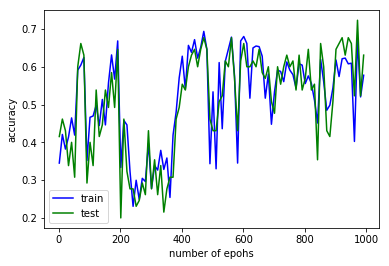

In [56]:
plt.plot(range(1, 1001, 10), history_arr[:, 0], 'b')
plt.plot(range(1, 1001, 10), history_arr[:, 1], 'g')
plt.xlabel('number of epohs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

In [61]:
def get_preds_and_true(model, loader, dataset):
    y_pred = np.zeros((len(dataset),))
    y_true = np.zeros((len(dataset),))
    offset = 0
    for i, (ecg, label_idx) in enumerate(loader):

        src = ecg.to(device).float()
        trg = label_idx.to(device).long()

        output = model(src)
        
        answer = output.argmax(dim = 1).long()
        l = len(answer)

        y_pred[offset:offset+l] = answer.cpu().numpy()
        y_true[offset:offset+l] = trg.cpu().numpy()

        offset = offset + l
        
    return y_pred, y_true

In [62]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [63]:
def plot_confusion_matrix( y_test_predict, y_test):
    sn.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)
   

In [64]:
y_pred, y_true = get_preds_and_true(model, valid_loader, valid_dataset)

In [65]:
np.sum(y_pred==y_true)/len(y_pred)

0.676923076923077

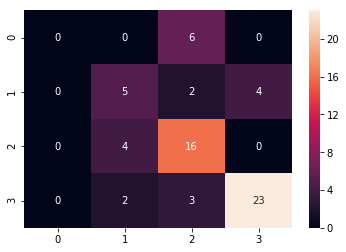

In [66]:
plot_confusion_matrix(y_pred, y_true)

In [67]:
from sklearn import metrics

In [68]:
metrics.f1_score(y_true, y_pred, average=None)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.        , 0.45454545, 0.68085106, 0.83636364])

In [69]:
metrics.recall_score(y_true, y_pred, average=None)

array([0.        , 0.45454545, 0.8       , 0.82142857])

In [70]:
metrics.precision_score(y_true, y_pred, average=None)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.        , 0.45454545, 0.59259259, 0.85185185])

In [71]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [72]:
save_model(model, 'cnn_spectro.pt')